# Nonlinearly-Observed LDS

## Some background
For notation, we write $\mathcal{S} \subset \mathbb{R}^{d_s}, \mathcal{O} \subset \mathbb{R}^{d_o}, \mathcal{U} \subset \mathbb{R}^{d_u}, \mathcal{Z} \subset \mathbb{R}^{d_l}$ to be the state, observation, control, and embedding vector spaces, respectively. In this notebook, we will experiment under the following model: 

We suppose that there is a ground truth linear dynamical system with states $x_t \in \mathcal{S}$, controls $u_t \in \mathcal{U}$, and dynamics
$$x_{t+1} = A x_t + B u_t$$
for some linear transformations $A : \mathcal{S} \rightarrow \mathcal{S}$ and $B: \mathcal{U} \rightarrow \mathcal{S}$. As usual, we require $\|A\|_{op} < 1$ for Lyapunov stability. We will be observing this LDS with a nonlinear (_and injective!_) observation function $g: \mathcal{S} \rightarrow \mathcal{O}$. The costs are the usual quadratic $\ell(x) = \|x\|^2$.

Of course, this induces (nonlinear) dynamics on the iterates $g(x_t)$ in $\mathcal{O}$, but we know that there is a ground truth LDS to be recovered. We seek lifting maps $f: \mathcal{O} \rightarrow \mathcal{Z}$ to recover the linear dynamics; morally, we want $f \circ g$ to be the identity. In fact, it can be a bit more general, see below.

#### <u>Proposition</u>: A lifting map $f$ yields a faithful, linearizing, and cost-preserving representation of the original dynamical system $(A, B)$ <u>if and only if</u> $f \circ g$ is a linear isometry over $range(A) \oplus range(B)$.

#### <u>Proof</u>: 
Check the overleaf for the proof, but it goes something like the following. Let $T: \mathcal{S} \rightarrow \mathcal{Z}$ denote $f \circ g$.

($\implies$) Suppose $f$ yields a faithful, linearizing, and cost-preserving representation. Then, $\ell(x) = \ell(Tx)$ for all reachable $x \in \mathcal{S}$ implies that $\|x\|^2 = \|Tx\|^2$, and so $T$ is an isometry where it matters. This also means that $T(0) = 0$. Next, since it's linearizing, there are some $\tilde{A}: \mathcal{Z} \rightarrow \mathcal{Z}$ and $\tilde{B}: \mathcal{U} \rightarrow \mathcal{Z}$ for which $$\tilde{A}Tx_t + \tilde{B}u_t = Tx_{t+1} = T(Ax_t + Bu_t)$$
Since this must hold for all states and controls, we find that $\tilde{A} T = TA$ and $\tilde{B} = TB$. Immediately, we see that $T$ must be linear over $range(A) \oplus range(B)$.

($\impliedby$) Suppose $f$ is a linear isometry over $range(A) \oplus range(B)$. Then, $\|x\|^2 = \|Tx\|^2$ for all reachable $x \in \mathcal{S}$ implies that $\ell(x) = \ell((f \circ g)x)$, and so $f$ preserves costs. Since $T$ is a linear isometry, then $T$ has trivial kernel and so is injective, meaning the representation is faithful. Lastly, we can confirm that the system is linearized with any dynamics $(\tilde{A}, \tilde{B})$ satisfying $T^{-1}\tilde{A}T = A$ and $\tilde{B} = TB$. If $d_s = d_l$ and we are lifting to the correct dimension, then $T$ is automatically invertible and these dynamics $(\tilde{A}, \tilde{B})$ are unique. $\blacksquare$

## Defining our tests
It seems that we get exactly what we want if and only if $f \circ g$ is a linear isometry over the reachable states. So, it makes sense to test if we can produce a linear isometry under more and more complex/interesting choices of $g$. All that really changes in the different experiments in this notebook is our selection of $g$, the dimensions $d_s, d_u, d_l$, and the system matrices $A, B$. So, we will write the code the rest below.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS, Gym
from extravaganza.observables import Observable, TimeDelayedObservation, Trajectory
from extravaganza.sysid import Lifter
from extravaganza.utils import summarize_lds, sample, jkey, opnorm, SAMPLING_METHOD

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp423ivxt9
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp423ivxt9/_remote_module_non_scriptable.py


In [2]:
def run(observable, ds: int, du: int, dl: int,
        T0: int, reset_every: int, sysid_args):
    """
    fn to gather data and train a sysid.
    """
    # make system
    done = False
    while not done:
        system = LDS(ds, du, 'none', 'quad', seed=SYSTEM_SEED)
        A, B = system.A, system.B
        done = opnorm(A) > 0.1 and jnp.linalg.norm(B) > 0.1
    print(summarize_lds(A, B))

    # make sysid
    sysid = Lifter(state_dim=dl, **sysid_args)

    # interaction loop
    control = jnp.zeros(du)
    max_sq_norm = 0.
    traj = Trajectory()
    for t in tqdm.trange(T0):
        if t % reset_every == 0: 
            system.reset()
            system.state = sample(jkey(), (ds,), sampling_method='sphere')
            sysid.end_trajectory()
            traj = Trajectory()
        cost, state = system.interact(control)
        traj.add_state(cost, state)
        obs = observable(traj)
        control = sysid.explore(cost, obs)
        traj.add_control(control)
        max_sq_norm = max(max_sq_norm, jnp.linalg.norm(state) ** 2)
    sysid.end_exploration(wordy=True)
    return A, B, sysid, max_sq_norm

In [3]:
def generate(observable, A, B, sysid, max_sq_norm, sampling_method='ball', 
             N=1000, reset_every=10, hh=10, use_pbar=True):
    ds, du = B.shape
    do, dl = sysid.obs_dim, sysid.state_dim
    states = []
    observations = []
    embeddings = []
    if use_pbar: pbar = tqdm.tqdm(total=N)
    while len(embeddings) < N:
        if len(embeddings) % reset_every == 0:
            traj = Trajectory()
            x = (max_sq_norm ** 0.5) * sample(jkey(), (ds,), sampling_method=sampling_method)
            for _ in range(hh):
                u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
                traj.add_control(u)
                x = A @ x + B @ u
                traj.add_state(jnp.linalg.norm(x) ** 2, x)
                
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        x = A @ x + B @ u
        cost = jnp.linalg.norm(x) ** 2
        traj.add_state(cost, x)
        obs = observable(traj)
        emb = sysid.get_state(obs, cost)        
        states.append(x)
        observations.append(obs)
        embeddings.append(emb)
        if use_pbar: pbar.update(1)
    if use_pbar: pbar.close()
    states, observations, embeddings = map(lambda arr: jnp.stack(arr, axis=0), (states, observations, embeddings))
    states, observations, embeddings = states.reshape(N, ds), observations.reshape(N, do), embeddings.reshape(N, dl)
    return states, observations, embeddings

In [4]:
def summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=1000, reset_every=10, hh=10):
    """
    We know that if we have succeeded, our embedding composed with our observation function is a linear transformation of the original state.
    Below, we regress this transformation, C, and compute some errors with it.
    """
    Ahat, Bhat = sysid.A, sysid.B
    ds, du = B.shape
    assert du == sysid.control_dim, (du, sysid.control_dim)
    do, dl = sysid.obs_dim, sysid.state_dim, 
    
    states, _, embeddings = generate(observable, A, B, sysid, max_sq_norm, sampling_method, N, reset_every, hh)

    # -------- FORWARD DIRECTION, showing that T = f \circ g linearizes ------------------------
    print('forward direction:')
    C_forward = jnp.linalg.lstsq(states, embeddings, rcond=-1)[0].T
    print('\t||Ahat @ C - C @ A||^2: \t{}'.format(jnp.linalg.norm(Ahat @ C_forward - C_forward @ A) ** 2))
    print('\t||Bhat - C @ B||^2: \t\t{}'.format(jnp.linalg.norm(Bhat - C_forward @ B) ** 2))

#     residuals = (C_forward[None] @ states[:, :, None]).squeeze() - embeddings
#     residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
#     state_norms = jnp.linalg.norm(embeddings, axis=-1) ** 2
#     print('\tAvg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
#     plt.scatter(state_norms, residual_norms)
#     plt.show()

    # -------- REVERSE DIRECTION, showing that T^{-1} = (f \circ g)^{-1} linearizes -----------------------
    print('reverse direction:')
    C_reverse = jnp.linalg.lstsq(embeddings, states, rcond=-1)[0].T
    print('\t||A @ C - C @ Ahat||^2: \t{}'.format(jnp.linalg.norm(A @ C_reverse - C_reverse @ Ahat) ** 2))
    print('\t||B - C @ Bhat||^2: \t\t{}'.format(jnp.linalg.norm(B - C_reverse @ Bhat) ** 2))

#     residuals = (C_reverse[None] @ embeddings[:, :, None]).squeeze() - states
#     residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
#     state_norms = jnp.linalg.norm(states, axis=-1) ** 2
#     print('\tAvg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
#     plt.scatter(state_norms, residual_norms)
#     plt.show()

    print()
    print('injectivity: \t||C_reverse @ C_forward - I_ds||^2 / ds^2 = {}'.format(jnp.linalg.norm(C_reverse @ C_forward - jnp.eye(ds)) ** 2 / ds ** 2))
    print('surjectivity: \t||C_forward @ C_reverse - I_dl||^2 / dl^2 = {}'.format(jnp.linalg.norm(C_forward @ C_reverse - jnp.eye(dl)) ** 2 / dl ** 2))
    
    print()
    print('singular values of C_forward: \t{}'.format(jnp.linalg.svd(C_forward)[1]))
    print('singular values of C_reverse: \t{}'.format(jnp.linalg.svd(C_reverse)[1]))
    if hasattr(sysid, 'fmean'): print('sqrt(fmean): \t\t{}'.format(sysid.fmean ** 0.5))
    pass

In [5]:
def print_prediction(observable, A, B, sysid, max_sq_norm, k=1, sampling_method='ball', hh=10):
    """
    See some prediction instances
    Here, 'original' means (f \circ g)(x_t), 'gt' means (f \circ g)(x_{t+k}), and 
        'pred' is the predicted embedding at t+k using linear dynamics given by (Ahat, Bhat).
    All norms are in the embedding space
    """
    Ahat, Bhat = sysid.A, sysid.B
    
    traj = Trajectory()
    x = (max_sq_norm ** 0.5) * sample(jkey(), (ds,), sampling_method=sampling_method)
    for _ in range(hh):
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        x = A @ x + B @ u
        traj.add_state(jnp.linalg.norm(x) ** 2, x)
    
    s = sysid.get_state(observable(traj), jnp.linalg.norm(x) ** 2)
    original = s.copy()
    for _ in range(k):
        u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(u)
        x = A @ x + B @ u
        traj.add_state(jnp.linalg.norm(x) ** 2, x)
        s = Ahat @ s + Bhat @ u
    gt = sysid.get_state(observable(traj), jnp.linalg.norm(x) ** 2)
    pred = s.copy()
    print(f'||gt - original||={jnp.linalg.norm(gt - original)}\t||pred - original||={jnp.linalg.norm(pred - original)}\t||gt - pred||={jnp.linalg.norm(gt - pred)}')
    pass

In [6]:
def plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', N=2000, reset_every=10, hh=10):
    assert A.shape[0] == 1 and sysid.state_dim == 1

    xs, os, zs = generate(observable, A, B, sysid, max_sq_norm, sampling_method, N, reset_every, hh)
    idxs = jnp.argsort(xs.squeeze())
    xs, os, zs = xs[idxs].reshape(-1), os[idxs].reshape(*os.shape), zs[idxs].reshape(-1)
    zs = zs * (sysid.fmean ** 0.5)

    do = os.shape[1]
    fig, ax = plt.subplots(nrows=do, ncols=2, figsize=(12, do * 5))
    ax = ax.reshape(do, 2)
    _xs, _zs = xs, zs
    for i in range(do):
        _os = os[:, i]
#         ax[i, 0].plot(_xs, _os, 'r--')
#         ax[i, 0].plot(_xs, _zs, 'b--')
#         ax[i, 1].plot(_os, _xs, 'c--')
#         ax[i, 1].plot(_os, _zs, '--', color='purple')
#         _xs, _os, _zs = map(lambda arr: arr[idx1:idx2], [_xs, _os, _zs])
        ax[i, 0].scatter(_xs, _os, color='r', label='obs(x)')
        ax[i, 0].scatter(_xs, _zs, color='b', label='(embedding \circ obs)(x)')
        ax[i, 1].scatter(_os, _xs, color='c', label='x(obs)')
        ax[i, 1].scatter(_os, _zs, color='purple', label='embedding(obs)')

        ax[i, 0].set_title('state space')
        ax[i, 0].set_xlabel('state')
        ax[i, 1].set_xlabel('observation_{}'.format(i))
        ax[i, 1].set_title('{}th coord of observation space'.format(i))
        ax[i, 0].legend(); ax[i, 1].legend()
    plt.show()
    pass

# (1) Identity observation (as a sanity check)
We consider the map $g$ sending $x \mapsto x$. The dynamics are linear w.r.t. these observations, and so our neural network really only needs to learn the identity map (or any linear map). Let's see how it does!

In [7]:
# # dimensions
# ds, du, dl = 4, 2, 4

# # define observation fn
# g = lambda x: x
# observable = lambda traj: g(traj.x[-1])
# do = ds

# # send it
# T0 = 2000
# reset_every = 10
# exploration_args = {'scales': 0.5, 'avg_len': 5}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,

#     'max_traj_len': int(1e6),

#     'exploration_args': {'random 0.75': exploration_args,
#                          'impulse 0.25': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'learned',

#     'sigma': 0.,
#     'determinstic_encoder': True,
#     'depth': 3,
#     'num_epochs': 16000,
#     'lifter_lr': 0.0012,

#     'seed': SYSID_SEED,
# }
# A, B, sysid, max_sq_norm = run(observable, ds, du, dl, T0, reset_every, sysid_args)

In [8]:
# # check things
# summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every)
# print('\npredictions:')
# for _ in range(5):
#     print_prediction(observable, A, B, sysid, max_sq_norm, sampling_method='ball', k=1)

# (2) Nonlinear injective observation with $d_s=d_o=d_l=1$
Here, we play with systems with 1-dimensional states for plotting and interpretation convenience. In particular, $A$ is a scalar, $B$ is a $1 \times d_u$ column vector, and we use the observation function $g: \mathbb{R} \rightarrow \mathbb{R}$ given by
$$g(x) := sign(x) \cdot \sqrt{|x|}$$
As we see, this is nonlinear (looks sorta sigmoidal), but it is invertible. Let's see what happens!

In [9]:
# # dimensions
# ds, du, dl = 1, 4, 1

# # define observation fn
# g = lambda t: jnp.sign(t) * (jnp.abs(t) ** 0.5)
# observable = lambda traj: g(traj.x[-1])
# do = ds

# # send it
# T0 = 500
# reset_every = 10
# exploration_args = {'scales': 0.5, 'avg_len': 5}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,

#     'max_traj_len': int(1e6),

#     'exploration_args': {'random 0.75': exploration_args,
#                          'impulse 0.25': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'regression_nograd',

#     'sigma': 0.,
#     'determinstic_encoder': True,
#     'depth': 8,
#     'num_epochs': 16000,
#     'lifter_lr': 0.0012,

#     'seed': SYSID_SEED,
# }
# A, B, sysid, max_sq_norm = run(observable, ds, du, dl, T0, reset_every, sysid_args)

In [10]:
# # check linearization and plot some stuff
# summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every)
# plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, N=200)

# (3) Nonlinear 2-to-1 observation with $d_s=d_l=1$
Again, we use 1-dimensional stuff here; we will look into how this scales as we increase dimension later. Now, our observation function $g: \mathbb{R} \rightarrow \mathbb{R}$ is given by
$$g(x) := x^2$$
This is nonlinear and **not injective**. Two distinct states ($x$ and $-x$) will produce the same observations, and yet they will evolve differently. For example, if we knew $g(x_{t})$, $u_t$, and $g(x_{t-1})$, then we can differentiate between the two states that produce the same observation. We will investigate the efficacy of such ***time-delayed observations*** below.

As a clarifying example, suppose $d_u=1$ and $A=B=1$ (i know its only semistable, but simple constants). Then, while the map $x \mapsto x^2$ is not injective, the map $x_{t} \mapsto (x_{t-1}^2, u_t, x_t^2)$ is. To see this, let us construct a left inverse. Note that $$x_t = x_{t-1} + u_t \implies x_t^2 = x_{t-1}^2 + u_t^2 + 2u_tx_{t-1} \implies x_{t-1} = \frac{x_t^2 - x_{t-1}^2}{2u_t} - \frac{u_t}{2}$$
Therefore, using only the variables $(x_{t-1}^2, u_t, x_t^2)$ we may write
$$x_t = \frac{x_t^2 - x_{t-1}^2}{2u_t} + \frac{u_t}{2}$$
This time-delayed observation with $d_o = 3$ is enough to faithfully represent the system, which realizes the upper bound $d_o \leq 3$ given by the Takens embedding (more on this later). (In fact, in this case we can do it with only $d_o=2$ using the variables $(x_t^2 - x_{t-1}^2, u_t) = (g(x_t) - g(x_{t-1}), u_t)$, though this only works here because of the properties of quadratics).

We attempt to have our method learn a linearization to this representation below.

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (LDS) for the LDS we are !!!NOT!!! reporting the costs with the `u.T @ R @ u` part
INFO: (LDS): initial state is [0.15799755]
INFO: (LDS) for the LDS we are !!!NOT!!! reporting the costs with the `u.T @ R @ u` part
INFO: (LDS): initial state is [0.6135401]


||A||_op = 0.9496432542800903
||B||_F = 0.5229992866516113
||A-BK||_op = 0.5869340896606445


INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.75000006 0.25      ]
5002it [00:04, 1032.22it/s]                                                                                                                          
INFO: (PC3): decoder provided, so reconstruction error WILL be computed


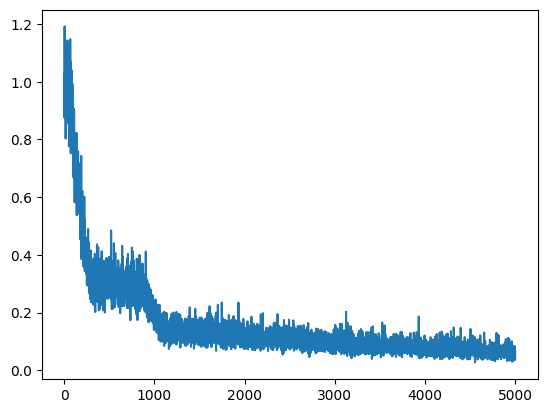

INFO: (PC3): using "learned" method to get the AB matrices during each training step
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2950.83it/s]
INFO: (LIFTER): ending sysid phase at step 5000
INFO: training!
INFO: mean loss for iters -2400 - 0:
INFO: 		reconstruction: 0.00024034138186834753
INFO: 		l2 linearization: 0.9608853459358215
INFO: 		guess the control: 62.95237350463867
INFO: 		simplification: 0.2519432008266449
INFO: 		injectivity: 0.003971772734075785
INFO: mean loss for iters 0 - 2400:
INFO: 		reconstruction: 0.004053784871551519
INFO: 		l2 linearization: 0.0234072208465174
INFO: 		guess the control: 1.0028280170525734
INFO: 		simplification: 0.24191482018019694
INFO: 		injectivity: 0.0025356729928413795
INFO: mean loss for iters 2400 - 4800:
INFO: 		reconstruction: 0.00133080094673763
INFO: 		l2 linearization: 0.006482413690197669
INFO: 		guess the control: 0.13029934397743395
INFO: 

regression:
||A||_op = 0.9774169325828552
||B||_F = 0.25533196330070496
||A-BK||_op = 0.7721686959266663

moments:
||A||_op = 0.5571475028991699
||B||_F = 0.05464445799589157
||A-BK||_op = 0.5547499656677246

learned:
||A||_op = 0.9780314564704895
||B||_F = 0.47352924942970276
||A-BK||_op = 0.6219728563524924



In [11]:
# dimensions
ds, du, dl = 1, 1, 1

# define observation fn
g = lambda t: t ** 2
hh = 2
observable = TimeDelayedObservation(hh=hh, control_dim=du, state_dim=ds,
                                    use_states=False, use_controls=True, 
                                    use_costs=True, use_cost_diffs=False,
                                    use_time=False)
do = observable.obs_dim

# send it
T0 = 5000
reset_every = 20
exploration_args = {'scales': 1., 'avg_len': 4}
sysid_args = {
    'obs_dim': do,
    'control_dim': du,

    'exploration_args': {'random 0.75': exploration_args,
                         'impulse 0.25': exploration_args,
                        },

    'method': 'nn',
    'AB_method': 'learned',
    
    'deterministic_encoder': False,

    'depth': 4,
    'num_iters': 24000,
    'batch_size': 64,
    'lifter_lr': 0.0012,
    'hh': hh + 1,

    'seed': SYSID_SEED,
}
A, B, sysid, max_sq_norm = run(observable, ds, du, dl, T0, reset_every, sysid_args)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 630.59it/s]


forward direction:
	||Ahat @ C - C @ A||^2: 	0.0006509670056402683
	||Bhat - C @ B||^2: 		0.0617062933743
reverse direction:
	||A @ C - C @ Ahat||^2: 	0.00047406365047208965
	||B - C @ Bhat||^2: 		0.2705190181732178

injectivity: 	||C_reverse @ C_forward - I_ds||^2 / ds^2 = 0.9997007846832275
surjectivity: 	||C_forward @ C_reverse - I_dl||^2 / dl^2 = 0.9997007846832275

singular values of C_forward: 	[0.01323989]
singular values of C_reverse: 	[0.01129856]
sqrt(fmean): 		0.8719338441632252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 622.27it/s]


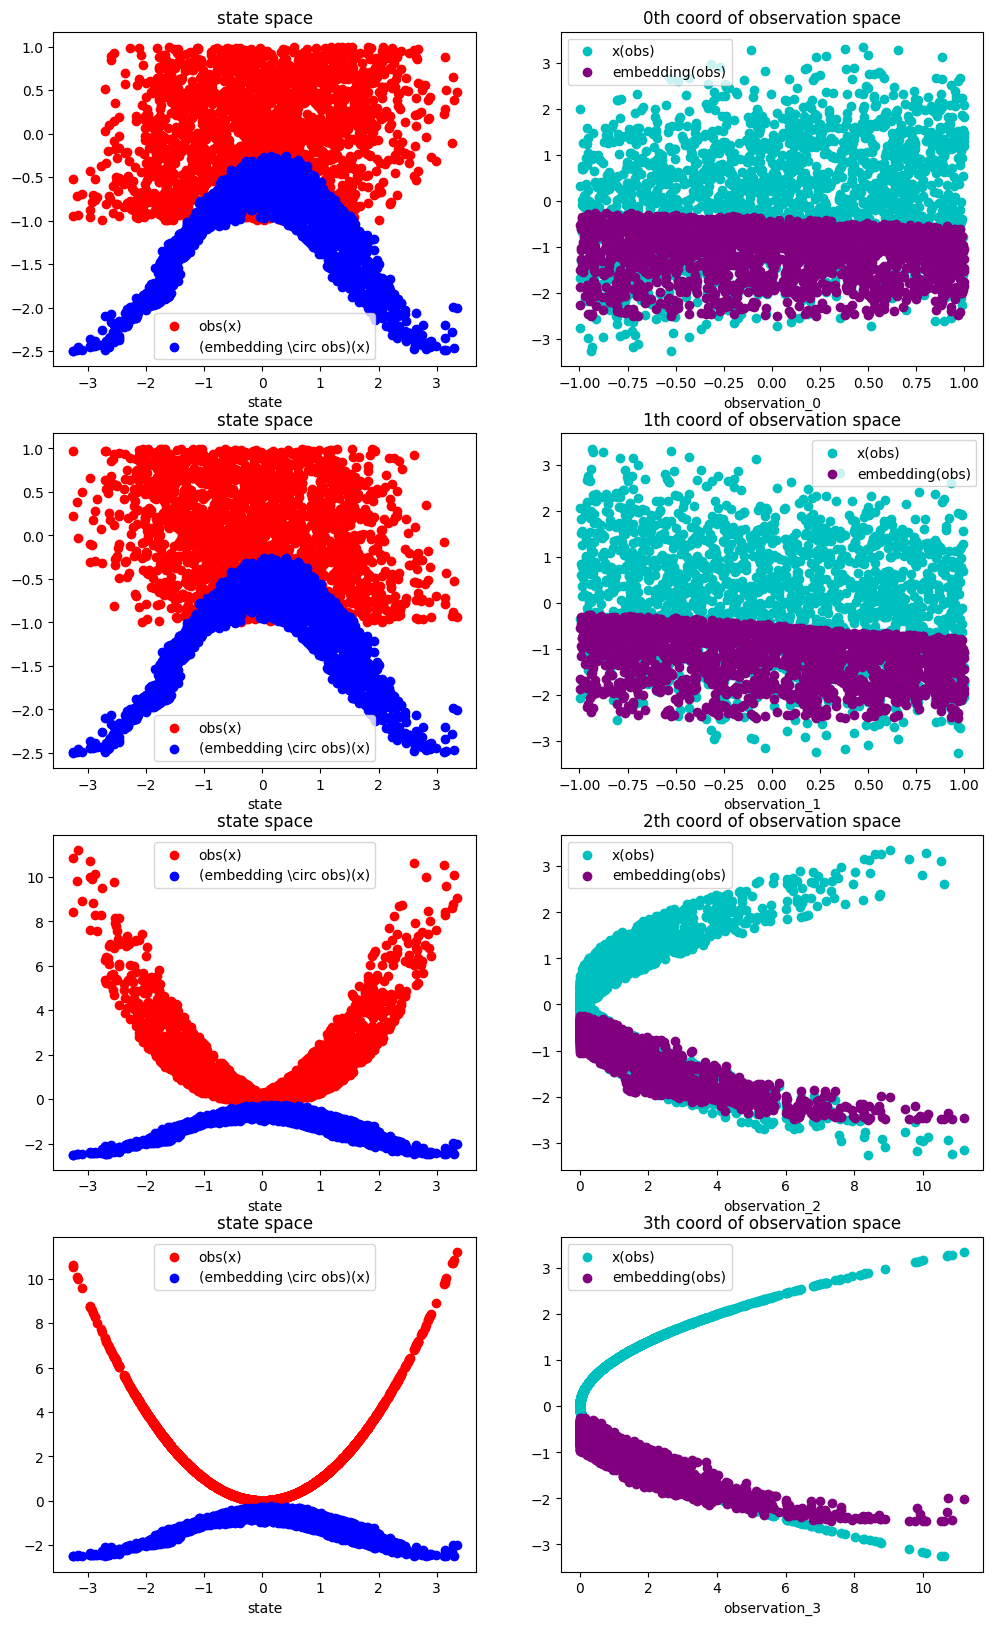

In [12]:
# you know the drill
summarize(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, hh=hh)
plot_1d(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=reset_every, N=2000, hh=hh)

Since we need it now, the general case for a 1-dimensional LDS would be 
$$x_{t} = Ax_{t-1} + Bu_t \implies x_t^2 = A^2x_{t-1}^2 + B^2u_t^2 + 2ABx_{t-1}u_t \implies x_{t-1} = \frac{x_t^2 - A^2x_{t-1}^2}{2ABu_t} - \frac{Bu_t}{2A} \implies x_t = \frac{x_t^2 - A^2x_{t-1}^2}{2Bu_t} + \frac{Bu_t}{2}$$

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 580.61it/s]


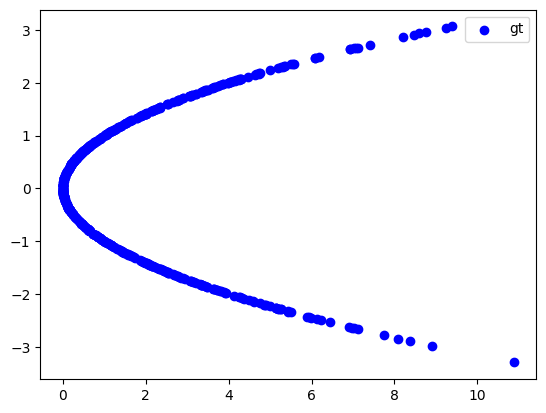

In [13]:
xs, os, zs = generate(observable, A, B, sysid, max_sq_norm, sampling_method='ball', reset_every=10, N=500, hh=hh)

costs, gt_states = [], []
for o in os:
    costs.append(o[3])
    cdiff = o[3] - A ** 2 * o[2]
    u = B * o[1]
    xhat = cdiff / (2 * u) + u / 2
    gt_states.append(xhat)
plt.scatter(costs, gt_states, color='b', label='gt')
plt.legend()
plt.show()